# Création d'un Réseau de Neurones Convolutionnel

## Classification d'images

### Import des libs

In [1]:
# Import de PyTorch
import torch
from torch import nn

# Import de TorchVision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import des outils
import matplotlib.pyplot as plt
import pandas as pd

from my_helper_functions import accuracy_fn, print_train_time, train_step, test_step, plot_training_data

print(f"PyTorch version : {torch.__version__}")
print(f"TorchVision version : {torchvision.__version__}")

PyTorch version : 2.5.1+cu118
TorchVision version : 0.20.1+cu118


### Le dataset

**Fashion-MNIST** est un ensemble de données d'images d'articles de Zalando, composé d'**un ensemble d'apprentissage de 60 000 exemples** et d'**un ensemble de test de 10 000 exemples**.

Chaque exemple est une image en **niveaux de gris** de **28x28**, associée à une étiquette parmi **10 classes**.

Zalando souhaite que **Fashion-MNIST** remplace directement l'ensemble de données **MNIST original** pour l'évaluation comparative des algorithmes d'apprentissage automatique.

Il partage la même taille d'image et la même structure de divisions d'entraînement et de test.

[Lien du dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

### CONSTANTES

In [2]:
RANDOM_STATE = 42

IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
NUMBER_OF_CLASSES = 10

### Obtenir les data de Fashion-MNIST

In [3]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=None)

### Comprendre nos datas

In [4]:
print("Train :\n")
print(f"train_data.data : {train_data.data.shape}")
print(f"train_data.targets : {train_data.targets.shape}")

print("\nTest :\n")
print(f"test_data.data : {test_data.data.shape}")
print(f"test_data.targets : {test_data.targets.shape}")

Train :

train_data.data : torch.Size([60000, 28, 28])
train_data.targets : torch.Size([60000])

Test :

test_data.data : torch.Size([10000, 28, 28])
test_data.targets : torch.Size([10000])


In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_names = [
 'T-shirt/top',
 'Pantalon',
 'Pull',
 'Robe',
 'Manteau',
 'Sandale',
 'Chemise',
 'Sneaker',
 'Sac',
 'Bottine'
]
class_names

['T-shirt/top',
 'Pantalon',
 'Pull',
 'Robe',
 'Manteau',
 'Sandale',
 'Chemise',
 'Sneaker',
 'Sac',
 'Bottine']

### Visualisation des datas

In [7]:
image, label = train_data[0]
print(f"image shape : {image.shape}")
print(f"label : {label}")

image shape : torch.Size([1, 28, 28])
label : 9


#### Explication de la shape
[1, 28, 28] = [canal de couleur, hauteur, largeur]

Text(0.5, 1.0, 'Bottine')

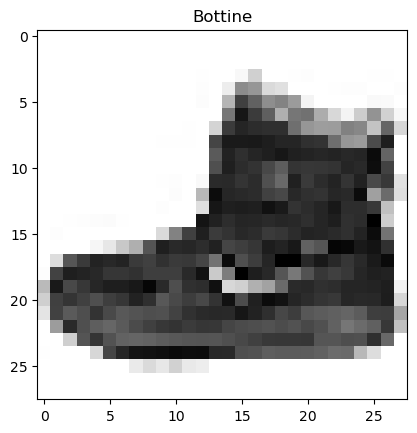

In [8]:
plt.imshow(image.squeeze(), cmap="Greys")
plt.title(class_names[label])

### Mise en oeuvre de la data sous forme de Mini-Batchs

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

### Comprendre nos Mini-Batch

In [10]:
print(f"Longueur du train dataloader: {len(train_dataloader)} mini-batchs de {BATCH_SIZE} éléments")
print(f"Longueur du test dataloader: {len(test_dataloader)} mini-batchs de {BATCH_SIZE} éléments")

Longueur du train dataloader: 1875 mini-batchs de 32 éléments
Longueur du test dataloader: 313 mini-batchs de 32 éléments


In [11]:
train_elements_batch, train_labels_batch = next(iter(train_dataloader))
print(f"train_elements_batch : {train_elements_batch.shape}")
print(f"train_labels_batch : {train_labels_batch.shape}")

train_elements_batch : torch.Size([32, 1, 28, 28])
train_labels_batch : torch.Size([32])


#### Explication de la shape
[32, 1, 28, 28] = [éléments du batch, canal de couleur, hauteur, largeur]

[32] = [labels du batch]

### Création d'un réseau de neurone : le modèle 1

#### On utilise la carte graphique (le GPU)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### On va transformer notre image en un vecteur

In [13]:
train_element = train_elements_batch[0]
print(f"Shape avant le flattening : {train_element.shape} -> [canal_couleur, hauteur, largeur]")

Shape avant le flattening : torch.Size([1, 28, 28]) -> [canal_couleur, hauteur, largeur]


In [14]:
flatten_model = nn.Flatten()
output = flatten_model(train_element)
print(f"Shape après le flattening: {output.shape} -> [canal_couleur, hauteur * largeur]")

Shape après le flattening: torch.Size([1, 784]) -> [canal_couleur, hauteur * largeur]


In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(IMAGE_HEIGHT*IMAGE_WIDTH, 10),
            nn.ReLU(),
            nn.Linear(10, NUMBER_OF_CLASSES)
        )
    
    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [16]:
model_1 = NeuralNetwork().to(device)
next(model_1.parameters()).device # vérifier le device du model

device(type='cuda', index=0)

In [17]:
from torchsummary import summary

summary(model_1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
              ReLU-3                   [-1, 10]               0
            Linear-4                   [-1, 10]             110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


### Loss et optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

### Phase d'entrainement

In [19]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

train_start = timer()

epochs = 5
train_loss_array = []
train_accuracy_array = []
test_loss_array = []
test_accuracy_array = []
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(dataloader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    train_loss_array.append(train_loss.detach().cpu().numpy())
    train_accuracy_array.append(train_acc)

    test_loss, test_acc = test_step(dataloader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss_array.append(test_loss.detach().cpu().numpy())
    test_accuracy_array.append(test_acc)

train_end = timer()

train_time_model_1 = print_train_time(start=train_start, end=train_end, device=device)
model_1_results = {"name": model_1.__class__.__name__,"loss": test_loss.item(), "accuracy": test_acc, "training_time": train_time_model_1}

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58736 | Train accuracy: 79.30%
Test loss: 0.56338 | Test accuracy: 80.71%

Epoch: 1
---------
Train loss: 0.51089 | Train accuracy: 82.36%
Test loss: 0.63231 | Test accuracy: 78.35%

Epoch: 2
---------
Train loss: 0.49213 | Train accuracy: 82.93%
Test loss: 0.52622 | Test accuracy: 82.64%

Epoch: 3
---------
Train loss: 0.48271 | Train accuracy: 83.17%
Test loss: 0.50595 | Test accuracy: 82.86%

Epoch: 4
---------
Train loss: 0.47525 | Train accuracy: 83.55%
Test loss: 0.52548 | Test accuracy: 82.26%

Train time on cuda: 75.251 seconds


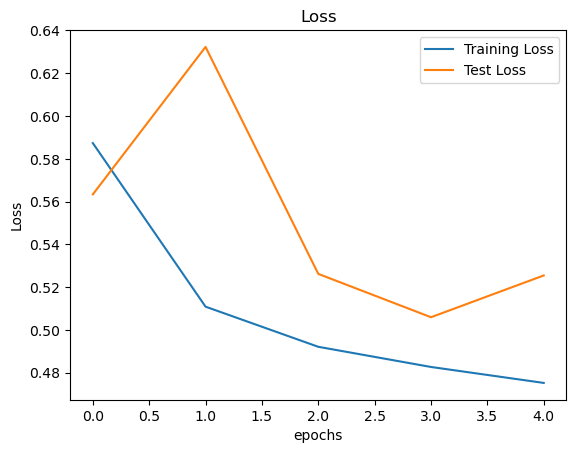

In [20]:
plot_training_data("Loss", train_loss_array, test_loss_array)

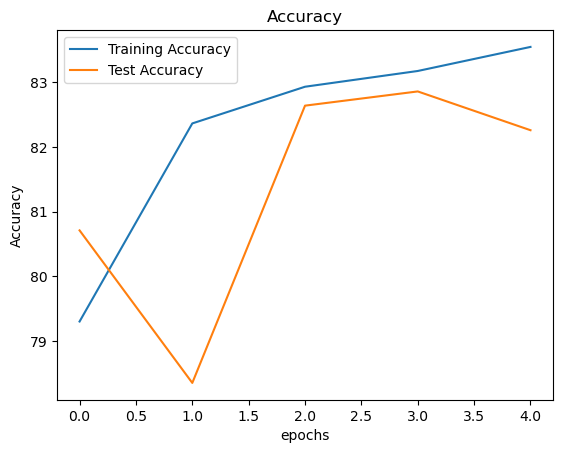

In [21]:
plot_training_data("Accuracy", train_accuracy_array, test_accuracy_array)

### Création d'un réseau de neurone convolutionnel (CNN) : le modèle 2

In [22]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=NUMBER_OF_CLASSES)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.convolutional_layer(x)
        x = self.linear_layer(x)
        return x

In [23]:
model_2 = ConvolutionalNeuralNetwork().to(device)
next(model_2.parameters()).device # vérifier le device du model

device(type='cuda', index=0)

In [24]:
summary(model_2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.61
Estimated T

### Loss et Optimizer

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.01)

### Phase d'entrainement

In [26]:
train_start = timer()

epochs = 5
train_loss_array = []
train_accuracy_array = []
test_loss_array = []
test_accuracy_array = []
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(dataloader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    train_loss_array.append(train_loss.detach().cpu().numpy())
    train_accuracy_array.append(train_acc)

    test_loss, test_acc = test_step(dataloader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_loss_array.append(test_loss.detach().cpu().numpy())
    test_accuracy_array.append(test_acc)

train_end = timer()
train_time_model_2 = print_train_time(start=train_start, end=train_end, device=device)
model_2_results = {"name": model_2.__class__.__name__, "loss": test_loss.item(), "accuracy": test_acc, "training_time": train_time_model_2}

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.45268 | Train accuracy: 83.46%
Test loss: 0.38690 | Test accuracy: 85.58%

Epoch: 1
---------
Train loss: 0.33986 | Train accuracy: 87.54%
Test loss: 0.37723 | Test accuracy: 86.29%

Epoch: 2
---------
Train loss: 0.32412 | Train accuracy: 88.05%
Test loss: 0.34532 | Test accuracy: 87.30%

Epoch: 3
---------
Train loss: 0.31146 | Train accuracy: 88.64%
Test loss: 0.34366 | Test accuracy: 87.55%

Epoch: 4
---------
Train loss: 0.30574 | Train accuracy: 88.84%
Test loss: 0.34783 | Test accuracy: 87.45%

Train time on cuda: 75.352 seconds


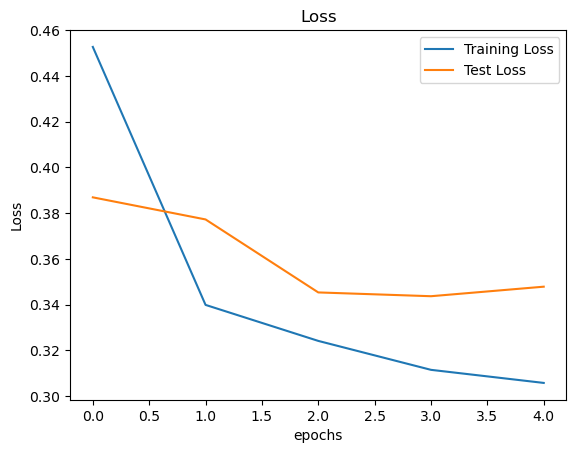

In [27]:
plot_training_data("Loss", train_loss_array, test_loss_array)

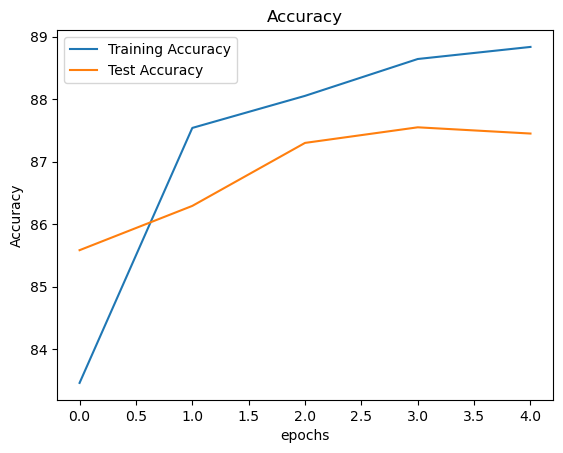

In [28]:
plot_training_data("Accuracy", train_accuracy_array, test_accuracy_array)

### Comparaison des modèles

In [29]:
compare_results = pd.DataFrame([model_1_results, model_2_results])
compare_results

,name,loss,accuracy,training_time
0,NeuralNetwork,0.525480,82.258387,75.250773
1,ConvolutionalNeuralNetwork,0.347828,87.450080,75.351760


Text(0, 0.5, 'model')

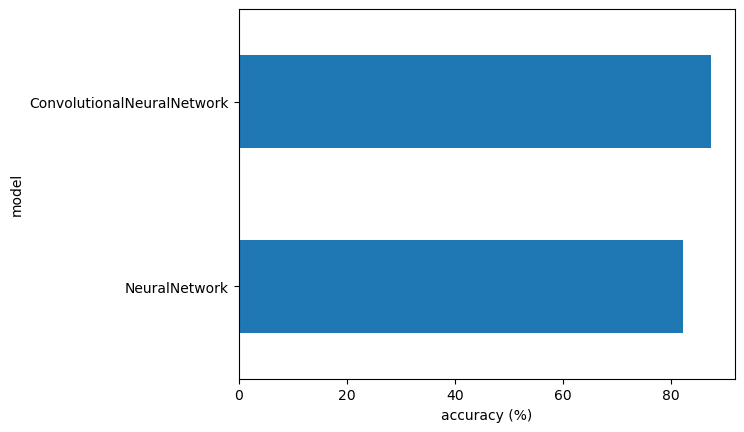

In [30]:
compare_results.set_index("name")["accuracy"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

### Évaluer les prédictions avec notre modèle

In [31]:
import random

torch.manual_seed(RANDOM_STATE)

exemples_elements = []
exemples_labels = []
for sample, label in random.sample(list(test_data), k=6):
    exemples_elements.append(sample)
    exemples_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {exemples_elements[0].shape}")
print(f"Test sample label: {exemples_labels[0]} ({class_names[exemples_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 8 (Sac)


In [32]:
pred_probs = []
model_2.eval()
with torch.inference_mode():
    for element in exemples_elements:
        # On adapte le shape de l'élément au batch (rajout d'une dimension avec unsqueeze) et on l'envoi au GPU
        element = torch.unsqueeze(element, dim=0).to(device)
        pred_logit = model_2(element)
        # On supprime une dimension pour utiliser softmax
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        pred_probs.append(pred_prob.cpu())

# Stack pred_probs pour convertir d'une list à un tensor
pred_probs = torch.stack(pred_probs)
pred_probs[:2]

tensor([[8.0355e-03, 2.1605e-05, 3.4826e-05, 8.8245e-06, 1.2781e-04, 4.1966e-02,
         3.4006e-04, 7.9781e-02, 8.4533e-01, 2.4359e-02],
        [7.4565e-18, 5.0144e-23, 3.6003e-15, 5.7242e-23, 3.0868e-20, 1.0000e+00,
         1.1329e-19, 1.0547e-09, 5.4592e-12, 1.1228e-10]])

In [33]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 5, 3, 7, 2, 5])

In [34]:
exemples_labels

[8, 5, 3, 9, 2, 5]

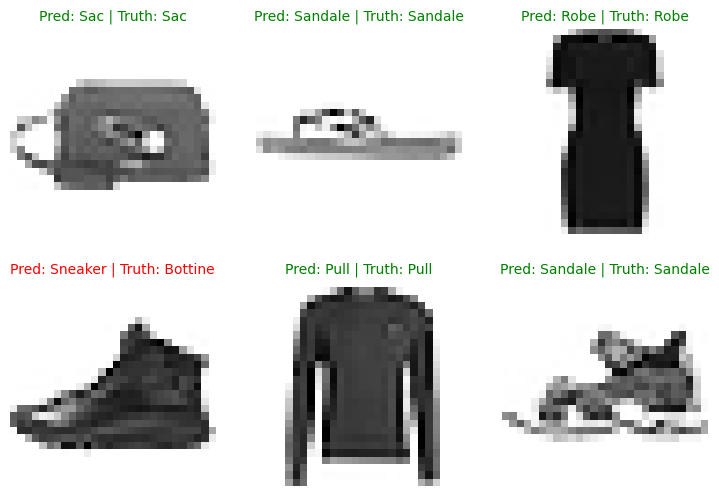

In [35]:
plt.figure(figsize=(9, 6))
nbr_rows = 2
nbr_cols = 3
for i, element in enumerate(exemples_elements):
    plt.subplot(nbr_rows, nbr_cols, i+1)
    plt.imshow(element.squeeze(), cmap="Greys")

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[exemples_labels[i]] 
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # vert si correct
    else:
        plt.title(title_text, fontsize=10, c="r") # rouge si erreur
    plt.axis(False)

### Utiliser une matrice de confusion pour évaluer

In [36]:
y_preds = []
model_2.eval()
with torch.inference_mode():
    for x, y in tqdm(test_dataloader, desc="Making predictions"):
        x, y = x.to(device), y.to(device)
        y_logit = model_2(x)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

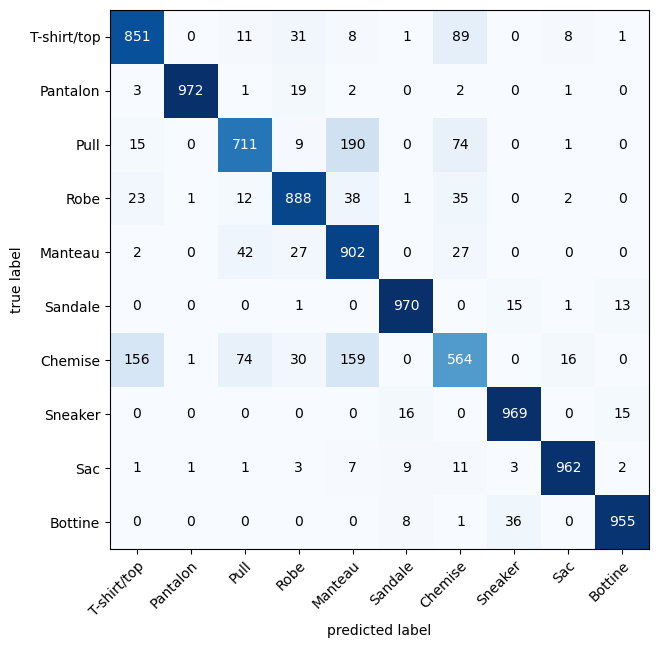

In [37]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10, 7))